<a href="https://colab.research.google.com/github/mwauquier/LYSL005_machine_creativity/blob/main/LYSL005_2022_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Générer du texte avec des RNN

Nous utiliserons pour cela un module adapté par Donald Dong qui permet d'entraîner rapidement un RNN pour la génération de texte, appelé `rnn-text-gen`. La documentation autour du module en question est [disponible sur Github](https://github.com/donaldong/rnn-text-gen).

Contrairement au module `markovify`, nous n'allons pas installer le module et l'importer comme n'importe quel module Python. Nous allons ici devoir récupérer le répertoire git et l'importer ici.

On commence pour cela par cloner le répertoire Git.

In [ ]:
!git clone https://github.com/donaldong/rnn-text-gen.git

fatal: destination path 'rnn-text-gen' already exists and is not an empty directory.


Il nous faut alors dire au système (ici, notre système virtuel) où se trouve le module que l'on a récupé. On le fait à l'aide du code dans la cellule suivante.

In [ ]:
import sys
sys.path.insert(0,'/content/rnn-text-gen')

Le module repose sur une version de TensorFlow antérieure à celle actuellement supportée par Google Colaboratory. Pour pouvoir faire tourner le module en l'état sans devoir en adapter le code pour le rendre compatible avec la version la plus récente de TensorFlow, on installe sur notre instance virtuelle la bonne version de TensorFlow.

In [ ]:
!pip uninstall tensorflow
!pip install tensorflow-gpu==1.15
!apt install --allow-change-held-packages libcudnn7=7.4.1.5-1+cuda10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcudnn7 is already the newest version (7.4.1.5-1+cuda10.0).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


Parce qu'il s'agit d'une version antérieure, certaines fonctions (ou du moins leur nom) sont considérées comme obsolètes. Vous aurez donc dans la suite du programme des messages de type 'Warning'. Cela n'empêche normalement pas le bon fonctionnement desdites fonctions.

Il nous faut maintenant importer les classes et libraires pertinentes

In [ ]:
# On importe les classes issues du module custom que nous avons cloné
from src.text_generator import RNNTextGenerator
from src.dataset import Dataset

# On importe les librairies classiques nécessaires pour la suite
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

On peut alors commencer à entraîner notre RNN.

On commence par charger notre corpus d'entraînement. Ici, le module vient avec quelques corpus, dont on peut regarder rapidement à quoi ils ressemblent.

In [ ]:
f = open('/content/rnn-text-gen/data/alice.txt')
text = f.read()
print(text[:400])

﻿ALICE'S ADVENTURES IN WONDERLAND

Lewis Carroll

CHAPTER I. Down the Rabbit-Hole

Alice was beginning to get very tired of sitting by her sister on the
bank, and of having nothing to do: once or twice she had peeped into the
book her sister was reading, but it had no pictures or conversations in
it, 'and what is the use of a book,' thought Alice 'without pictures or
conversations?'

So she was co


Il nous faut maintenant définir les paramètres d'entraînement. Parmi ces paramètres, on trouve :
- La taille des batchs (batch_size)
- La longueur des séquences (seq_length)
- Le nombre d'époch (epoch)
- Le taux d'apprentissage (learning_rate)

In [ ]:
seq_length = 25
learning_rate = 0.01
epoch = 1
batch_size = 25

On peut alors traiter le corpus, c'est-à-dire créer les vecteurs qui serviront d'input au RNN. Le présent module propose par la fonction Dataset de transformer le corpus en un ensemble de batchs comprenant *n* séquences de longueur *j* de vecteurs one-hot (où *n* correspond à la valeur définie par batch_size, et *j* à la longueur des séquences définie par seq_length)

Notons qu'ici, la fonction crée des vecteurs pour les caractères, mais on peut de façon générale choisir de faire des vecteurs pour les mots eux-mêmes et non les caractères.

De même, les RNNs peuvent prendre en entrée des vecteurs de type *word embeddings*, mais nous nous limiterons ici aux vecteurs one-hot.


In [ ]:
alice_dataset = Dataset(['/content/rnn-text-gen/data/alice.txt'], seq_length)

On peut alors entraîner le modèle à l'aide de la fonction `RNNTextGenerator()`. Un argument important de cette fonction est le type d'unités que l'on utilise (ici BasicRNNCell). On pourra plus tard utiliser des unités de type LSTM ou GRU pour entraîner les réseaux de neurones correspondants.

In [ ]:
rnn_model = RNNTextGenerator(
    seq_length,
    alice_dataset.vocab_size,
    rnn_cell=tf.nn.rnn_cell.BasicRNNCell,
    learning_rate=learning_rate,
    epoch=epoch,
    batch_size=batch_size,
)

Une façon d'évaluer nos paramètres et le degré de convergence de notre RNN consiste à voir comment évoluent la précision (Accuracy) et la fonction objectif (loss function).

On commence par faire converger le modèle sur nos données, et on sauvegarde les scores dans une variable.

In [ ]:
rnn_model_scores = rnn_model.fit(
    alice_dataset,
    save_scores=True
)

On peut alors produire une visualisation graphique de l'évolution de ces scores.

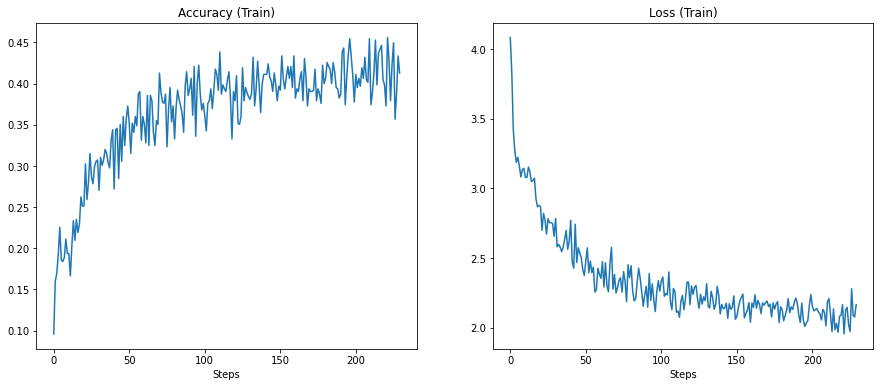

In [ ]:
fig, axes = plt.subplots(figsize=(15, 6), ncols=2)
rnn_model_scores['accuracy'].plot(
    ax=axes[0], title='Accuracy (Train)'
)
rnn_model_scores['loss'].plot(
    ax=axes[1], title='Loss (Train)'
)
for ax in axes:
    ax.set(xlabel='Steps')

La courbe de la fonction objectif doit normalement une courbe descendante d'abord rapide puis qui ralentit. Si la courbe ne se stabilise cependant pas (qu'il y a beaucoup de pics par exemple), on considère que le RNN n'a pas convergé. Un modèle ne converge pas quand la fonction objectif ne se stabilise pas. Une raison à cette non-convergence peut s'expliquer par le nombre limité d'epochs (1) que nous avons fixé. On peut donc choisir de réentraîner notre RNN avec un nombre d'epochs plus élevé, par exemple.

Sachez que l'on peut aussi affiner notre modèle sans le réentraîner de 0 en le va le 'fit' sur nos données (on peut considérer cela comme un epoch). On peut ainsi demander au modèle de s'affiner un certain nombre de fois, ou durant une certaine période, comme on le fait ci-dessous.

De façon assez intéressante, on peut suivre l'évolution en direct de ces scores et de l'état de la prédiction en temps réel à mesure que le RNN s'entraîne.

In [ ]:
# On importe la fonction native du module permettant de fixer une durée maximale à l'entraînement
from src.time_limit import time_limit

# On définit la durée de l'entraînement
for _ in time_limit(seconds=30): 
  # On affine le modèle
  rnn_model.fit(alice_dataset)
  acc, loss = rnn_model.score(alice_dataset)
  # On imprime à chaque epoch la précision et la valeur de la loss function
  print('test acc: {}, test loss: {}'.format(
        acc, loss
    ))
  # On demande à chaque epoch d'imprimer une séquence de 100 caractères prédits à partir de la séquence initiale 'Yes, but '
  start_seq = 'Yes, but '
  print(start_seq + alice_model.generate(
        alice_dataset,
        start_seq,
        100
    ))
  print('-----------------------')

Quelque soit la performance de votre RNN, il est en tout cas déjà prêt pour la génération de phrase. Générer une séquence se fait à l'aide de la fonction `generate()`. La fonction prend en argument le dataset (c'est-à-dire le dictionnaire contenant les équivalences entre les vecteurs one-hot et les symboles correspondants), la séquence à partir de laquelle prédire, et le nombre de caractères à prédire.

In [ ]:
# Pour des raisons de lisibilité, on définit la séquence d'amorce dans une variable à part
start_seq = 'Of course '

# On imprime ici directement l'amorce et le texte généré (mais on pourrait enregistrer le texte généré dans une variable par exemple)
print(start_seq + alice_model.generate(
        alice_dataset,
        start_seq,
        500
    ))

Comme dit plus haut, vous pouvez entraîner des RNN plus spécifiques, à savoir des LSTM et des réseaux de type GRU. Il suffit pour cela notamment de remplacer dans la fonction d'entraînement BasicRNNCell par LSTMCell ou CRUCell (et modifier les valeurs des autres arguments si besoin)

## Exercice

- Quels sont les paramètres qui vous permettent d'améliorer les résultats pour un petit corpus ?
- Quel est l'impact de la taille du corpus ?
- Quelle est la performance du RNN sur la prédiction du wikiCréole ?
- Quel est le type de réseau de neurones qui marche le mieux (sur vos données) ?

## Compléments

Notez par ailleurs que le module présenté ici intègre des fonctions de sélection de modèles. Ces fonctions vous permettent d'entraîner plusieurs réseaux en faisant varier automatiquement les paramètres (types de cellules, fonction d'optimisation, nombre d'epoch, etc), et d'identifier sur la base de ces différents modèles la configuration optimale.

Attention, en fonction de la variabilité que vous autorisez pour les différents paramètres, l'entraînement de ces différents modèles peut être très long.*italicized text*

In [ ]:
# On importe la fonction nécessaire
from src.model_selector import ModelSelector

# On définit les paramètres à faire varier
params = {
    'rnn_cell': [
        tf.nn.rnn_cell.BasicRNNCell,
        tf.nn.rnn_cell.LSTMCell,
        tf.nn.rnn_cell.GRUCell,
    ],
    'n_neurons': np.arange(1, 500),
    'activation': [
        tf.nn.leaky_relu,
        tf.nn.elu,
        tf.tanh,
    ],
    'optimizer': [
        tf.train.AdamOptimizer,
        tf.train.GradientDescentOptimizer,
    ],
    'learning_rate': np.linspace(0, 1, 10000, endpoint=False),
    'epoch': np.arange(1, 200),
    'batch_size': np.arange(25, 100),
}

# On entraîne l'ensemble des modèles au regard des paramètres fixés
config_models = ModelSelector(alice_dataset, params)

On peut alors sélectionner le ou les modèles optimaux à l'aide de la fonction `search()`.

Attention, là aussi la sélection peut être longue (vous allez potentiellement entraîner un très grand nombre de modèles). Vous pouvez donc là aussi fixer un délai maximal pour la réalisation de la fonction.

In [ ]:
for _ in time_limit(hours=24):
    config_models.search()

    # Cette ligne vous permet ensuite de sauvegarder dans un fichier csv les informations des 10 premiers résultats
    config_models.as_df().head(10).to_csv('alice_models.csv')